In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy import special
from scipy.spatial import distance
import seaborn as sns
from sklearn import metrics
import tqdm

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
digraph = nx.read_graphml('../../../scripture_graph.graphml')
print(nx.info(graph))
graph_lib.remove_topic_nodes(digraph)
graph_lib.remove_suggested_edges(digraph)
print(nx.info(digraph))

Name: 
Type: DiGraph
Number of nodes: 41995
Number of edges: 45985
Average in degree:   1.0950
Average out degree:   1.0950
Name: 
Type: DiGraph
Number of nodes: 41995
Number of edges: 45985
Average in degree:   1.0950
Average out degree:   1.0950


In [5]:
graph = digraph.to_undirected()
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 41995
Number of edges: 26946
Average degree:   1.2833


In [6]:
# How many (undirected) edges are possible?
possible = special.comb(graph.number_of_nodes(), 2, exact=True) - graph.number_of_nodes()
print(graph.number_of_edges(), possible, graph.number_of_edges() / possible * 100)

26946 881727020 0.00305604789110353


In [7]:
similarity = graph_lib.jaccard(graph)

/home/kearnes/miniconda3/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


In [8]:
nonzero = graph_lib.get_nonzero_edges(graph, similarity)
nonzero.shape[0] / possible * 100

0.010802322923028943

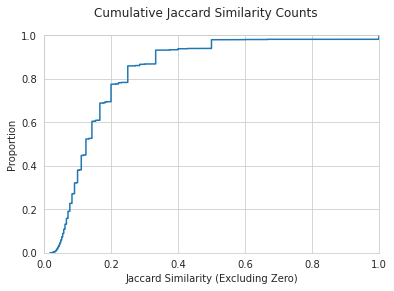

In [9]:
sns.set_style('whitegrid')
fig, ax = subplots()
sns.ecdfplot(data=nonzero, x='jaccard', ax=ax)
suptitle('Cumulative Jaccard Similarity Counts')
ax.set_xlabel('Jaccard Similarity (Excluding Zero)')
ax.set_xlim(0, 1)
fig.savefig('jaccard-cdf.png', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='intersection', ylabel='jaccard'>

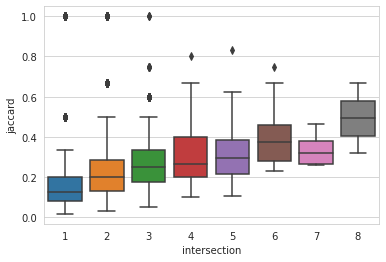

In [10]:
sns.boxplot(data=nonzero, x='intersection', y='jaccard')

<AxesSubplot:xlabel='intersection', ylabel='union'>

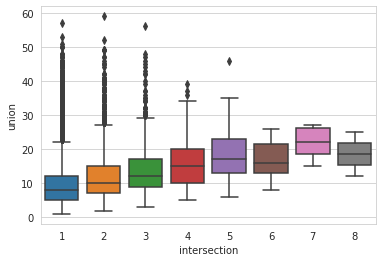

In [11]:
sns.boxplot(data=nonzero, x='intersection', y='union')

In [12]:
nonzero.sort_values('intersection', ascending=False)

,index,a,b,jaccard,intersection,union,exists
85483,136840,D&C 18:26,D&C 90:9,0.666667,8,12,True
80706,124485,D&C 101:7,Mosiah 21:15,0.320000,8,25,True
90849,156269,D&C 8:3,Mosiah 7:19,0.259259,7,27,True
71970,104998,3 Ne. 25:1,D&C 29:9,0.269231,7,26,True
81887,126913,D&C 107:33,D&C 19:27,0.333333,7,21,True
...,...,...,...,...,...,...,...
32783,39270,Alma 41:11,Isa. 26:11,0.142857,1,7,False
32782,39269,Alma 11:39,Isa. 26:11,0.076923,1,13,False
32781,39268,2 Ne. 26:12,Isa. 26:11,0.066667,1,15,False
32780,39267,1 Ne. 19:10,Isa. 26:11,0.027778,1,36,False


In [13]:
nonzero.sort_values('union', ascending=False)

,index,a,b,jaccard,intersection,union,exists
62708,86512,1 Ne. 19:10,2 Ne. 25:20,0.033898,2,59,True
59470,81230,1 Ne. 19:10,1 Ne. 1:4,0.017544,1,57,False
62802,86606,1 Ne. 19:10,Mosiah 7:19,0.053571,3,56,True
62713,86517,1 Ne. 19:10,2 Ne. 31:21,0.018868,1,53,False
62797,86601,1 Ne. 19:10,Mosiah 3:5,0.038462,2,52,False
...,...,...,...,...,...,...,...
66057,93006,2 Ne. 21:6,2 Ne. 30:12,1.000000,1,1,False
92658,166668,Hel. 1:30,Hel. 4:8,1.000000,1,1,False
92659,166669,Hel. 11:24,Hel. 1:32,1.000000,1,1,False
87769,143866,D&C 41:3,D&C 58:23,1.000000,1,1,False


In [14]:
nonzero.sort_values('jaccard', ascending=False)

,index,a,b,jaccard,intersection,union,exists
72462,105942,3 Ne. 28:15,Ether 3:8,1.000000,1,1,False
17430,19586,3 Ne. 28:35,Deut. 8:11,1.000000,1,1,False
4952,5224,1 Sam. 12:24,Neh. 12:43,1.000000,1,1,False
35999,43424,2 Ne. 18:17,Isa. 64:7,1.000000,1,1,False
36070,43519,Isa. 65:10,Josh. 7:26,1.000000,1,1,False
...,...,...,...,...,...,...,...
59865,81914,1 Ne. 10:12,1 Ne. 19:10,0.020000,1,50,False
85337,136483,D&C 17:1,Mosiah 7:19,0.020000,1,50,False
62751,86555,1 Ne. 19:10,D&C 19:27,0.019608,1,51,False
62713,86517,1 Ne. 19:10,2 Ne. 31:21,0.018868,1,53,False


In [15]:
nonzero[nonzero.jaccard == 1].sort_values('intersection', ascending=False)

,index,a,b,jaccard,intersection,union,exists
17027,19103,Deut. 5:17,Matt. 5:21,1.0,3,3,False
8359,9028,2 Kgs. 14:24,2 Kgs. 15:9,1.0,3,3,False
36293,43815,2 Ne. 18:6,Isa. 8:6,1.0,3,3,False
32560,39001,D&C 88:105,Isa. 21:9,1.0,2,2,False
26756,31356,1 Ne. 20:10,Gen. 15:13,1.0,2,2,False
...,...,...,...,...,...,...,...
18465,20796,Esth. 5:9,Prov. 27:3,1.0,1,1,False
18464,20795,Esth. 5:6,Esth. 9:12,1.0,1,1,False
18463,20794,Esth. 5:2,Esth. 8:4,1.0,1,1,False
18448,20777,Alma 47:22,Esth. 3:2,1.0,1,1,False


In [16]:
nonzero[nonzero.jaccard == 1].intersection.value_counts()

1    1689
2      31
3       3
Name: intersection, dtype: int64

In [17]:
nonzero[nonzero.jaccard == 1].exists.value_counts()

False    1723
Name: exists, dtype: int64

In [18]:
# singletons: no outgoing or incoming edges
num_singletons = 0
for node in graph.nodes:
    if not graph.edges(node):
        num_singletons += 1
print(num_singletons, graph.number_of_nodes(), num_singletons / graph.number_of_nodes())

22243 41995 0.5296582926538874


In [19]:
mask = (nonzero.intersection > 1) & (nonzero.jaccard < 1) & (~nonzero.exists)
nonzero[mask].sort_values(['intersection', 'jaccard'], ascending=False)

,index,a,b,jaccard,intersection,union,exists
42569,53085,Josh. 2:10,Neh. 9:11,0.600000,6,10,False
74580,110447,Alma 11:39,Mosiah 7:27,0.272727,6,22,False
68646,97962,2 Ne. 33:13,Morm. 9:30,0.833333,5,6,False
44857,56952,D&C 60:15,Luke 10:11,0.625000,5,8,False
47658,60866,D&C 24:15,Matt. 10:14,0.555556,5,9,False
...,...,...,...,...,...,...,...
62758,86562,1 Ne. 19:10,D&C 8:3,0.044444,2,45,False
62790,86594,1 Ne. 19:10,Mosiah 15:2,0.044444,2,45,False
66483,93960,2 Ne. 25:20,Mosiah 7:19,0.043478,2,46,False
59749,81724,1 Ne. 10:3,1 Ne. 19:10,0.040816,2,49,False


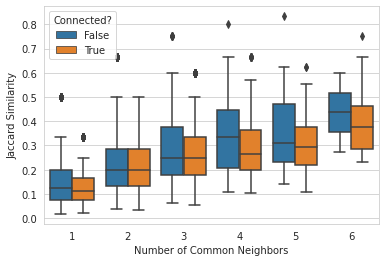

In [21]:
fig, ax = subplots()
mask = (nonzero.jaccard < 1) & (nonzero.intersection <= 6)
nonzero['Connected?'] = nonzero.exists
sns.boxplot(data=nonzero[mask], x='intersection', y='jaccard', hue='Connected?', ax=ax)
ax.set_ylabel('Jaccard Similarity')
ax.set_xlabel('Number of Common Neighbors')
fig.savefig('jaccard-box.png', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='jaccard', ylabel='Density'>

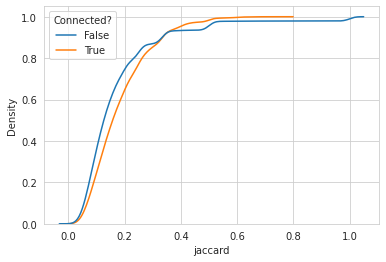

In [22]:
# Check for Simpson's paradox.
sns.kdeplot(data=nonzero, x='jaccard', hue='Connected?', common_norm=False, cumulative=True)

In [23]:
nonzero[nonzero.intersection == 3]

,index,a,b,jaccard,intersection,union,exists,Connected?
201,206,1 Chr. 16:8,Alma 37:37,0.150000,3,20,True,True
204,209,1 Chr. 16:8,D&C 46:32,0.230769,3,13,True,True
205,210,1 Chr. 16:8,D&C 59:7,0.230769,3,13,False,False
1047,1091,1 Chr. 9:3,2 Chr. 15:9,0.750000,3,4,False,False
1119,1165,1 Cor. 1:10,3 Ne. 11:28,0.272727,3,11,True,True
...,...,...,...,...,...,...,...,...
95111,187043,Mosiah 28:11,Mosiah 8:9,0.500000,3,6,False,False
95178,188872,Mosiah 7:6,Mosiah 9:1,0.272727,3,11,True,True
95180,188874,Mosiah 7:6,Omni 1:12,0.200000,3,15,True,True
95207,189453,Mosiah 8:13,Omni 1:20,0.187500,3,16,True,True
